<a href="https://colab.research.google.com/github/mtsizh/galaxy-morphology-manifold-learning/blob/main/morphology_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The code below downloads `gz_decals_volunteers_5.parquet` dataset and curates. We use only these datapoints where there were enough answers and high confidence.

In [1]:
#@title Download and curate table

from functools import partial
import operator
import numpy as np
import pandas as pd

print('DOWNLOADING TABLE')
!if [ ! -f "gz_decals_volunteers_5.parquet" ]; then wget https://zenodo.org/records/4573248/files/gz_decals_volunteers_5.parquet; fi

df = pd.read_parquet('gz_decals_volunteers_5.parquet')
working_columns = ['iauname',
                   'png_loc',
                   'smooth-or-featured_smooth_fraction',
                   'smooth-or-featured_total-votes',
                   'has-spiral-arms_yes_fraction',
                   'has-spiral-arms_total-votes',
                   'how-rounded_total-votes',
                   'how-rounded_round_fraction',
                   'how-rounded_in-between_fraction',
                   'how-rounded_cigar-shaped_fraction',
                   'disk-edge-on_total-votes',
                   'disk-edge-on_yes_fraction',
                   'disk-edge-on_no_fraction']


df = df[working_columns] # remove unnecessary columns
df['class'] = "" # add class column

lt = lambda x : np.isnan and partial(operator.gt, x)
gt = lambda x : np.isnan and partial(operator.lt, x)

conditions = {
    'has spiral arms': {'has-spiral-arms_yes_fraction': gt(0.8),
                        'has-spiral-arms_total-votes': gt(15)},
    'no spiral arms': {'has-spiral-arms_yes_fraction': lt(0.2),
                       'has-spiral-arms_total-votes': gt(15)},
    'round': {'how-rounded_round_fraction': gt(0.8),
              'how-rounded_total-votes': gt(10)},
    'inbetween': {'how-rounded_in-between_fraction': gt(0.8),
                  'how-rounded_total-votes': gt(10)},
    'cigar': {'how-rounded_cigar-shaped_fraction': gt(0.8),
              'how-rounded_total-votes': gt(10)},
    'edge on': {'disk-edge-on_yes_fraction': gt(0.8),
                'disk-edge-on_total-votes': gt(10)},
    'edge off': {'disk-edge-on_no_fraction': gt(0.8),
                 'disk-edge-on_total-votes': gt(10)},
    'smooth': {'smooth-or-featured_smooth_fraction': gt(0.8),
               'smooth-or-featured_total-votes': gt(10)},
    'featured': {'smooth-or-featured_smooth_fraction': lt(0.2),
                 'smooth-or-featured_total-votes': gt(10)}
}

for class_name, cond_rules in conditions.items():
  bool_arr = np.ones(len(df), dtype=bool)
  for col, condition_func in cond_rules.items():
    bool_arr &= condition_func(df[col])
  df.loc[bool_arr, 'class'] += f', {class_name}'

df['class'] = df['class'].str.lstrip(',')
df = df[df['class'] != ""] #remove unclassified

print('SAVING CURATED TABLE')
df.to_parquet('curated_dataset.parquet', index=False)

DOWNLOADING TABLE
--2024-12-17 13:09:34--  https://zenodo.org/records/4573248/files/gz_decals_volunteers_5.parquet
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.45.92, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40528939 (39M) [application/octet-stream]
Saving to: ‘gz_decals_volunteers_5.parquet’

gz_decals_volunteer 100%[===================>]  38.65M   729KB/s    in 55s     

2024-12-17 13:10:30 (717 KB/s) - ‘gz_decals_volunteers_5.parquet’ saved [40528939/40528939]

SAVING CURATED TABLE


Downloading and curating images based on curated table. Please note, the procedure is quite slow (downloading 4 parts x 20 min per part). Images are cropped to 120 x 120 central part. The result is archived in case you want to download it (final size will be approximately 400 Mb, the whole dataset is 4 parts x 20 Gb each).

In [ ]:
#@title Download and curate images
import zipfile
import pandas as pd
import os
from tqdm.auto import tqdm
import pathlib

df = pd.read_parquet('curated_dataset.parquet')
all_files = df['png_loc'].tolist()
all_files = [str(pathlib.Path(*pathlib.Path(f).parts[1:])) for f in all_files]

save_to_dir = 'curated_imgs'
if not os.path.exists(save_to_dir):
  os.makedirs(save_to_dir, exist_ok=True)

parts_urls = [
    'https://zenodo.org/records/4573248/files/gz_decals_dr5_png_part1.zip',
    'https://zenodo.org/records/4573248/files/gz_decals_dr5_png_part2.zip',
    'https://zenodo.org/records/4573248/files/gz_decals_dr5_png_part3.zip',
    'https://zenodo.org/records/4573248/files/gz_decals_dr5_png_part4.zip'
]

for part_idx, url in enumerate(parts_urls):
  print(f'PART {part_idx+1} of {len(parts_urls)}')
  _, filename = os.path.split(url)
  if not os.path.isfile(filename):
    !wget {url}
  if not os.path.isfile(filename):
    print(f'ERROR LOADING PART {part_idx+1}')
    continue
  print(f'UNZIPPING {filename}')
  with zipfile.ZipFile(filename) as z:
    files_in_part = list(set(all_files) & set(z.namelist()))
    with tqdm(total=len(files_in_part)) as progress:
      for filename1 in files_in_part:
        full_path = os.path.join(save_to_dir, filename1)
        path = pathlib.Path(full_path)
        path.parent.mkdir(parents=True, exist_ok=True)
        with open(full_path, 'wb') as f:
          f.write(z.read(filename1))
        progress.update()
  print('FILES EXTRACTED')
  !rm {filename}

from PIL import Image

# Define the cropping function
def crop_center(image, crop_width, crop_height):
    width, height = image.size
    left = (width - crop_width) // 2
    top = (height - crop_height) // 2
    right = left + crop_width
    bottom = top + crop_height
    return image.crop((left, top, right, bottom))

def count_files(folder):
    count = 0
    for root, _, files in os.walk(folder):
        count += len(files)
    return count

print('CROPPING IMAGES to 120x120')
with tqdm(total=count_files(save_to_dir)) as progress:
  for root, _, files in os.walk(save_to_dir):
      for file in files:
          file_path = os.path.join(root, file)
          with Image.open(file_path) as img:
            gray_img = img.convert("L")
            cropped_img = crop_center(gray_img, 120, 120)
            cropped_img.save(file_path)
            progress.update()

print('ZIPPING just in case')
!zip -q -r curated_imgs.zip curated_imgs curated_dataset.parquet && echo "zipped" || echo "zip error"

print('PROCESSING COMPLETE!')

PART 1 of 4
--2024-12-09 14:06:58--  https://zenodo.org/records/4573248/files/gz_decals_dr5_png_part1.zip
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.43.25, 188.185.45.92, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27789905885 (26G) [application/octet-stream]
Saving to: ‘gz_decals_dr5_png_part1.zip’

gz_decals_dr5_png_p 100%[===================>]  25.88G  20.5MB/s    in 21m 42s 

2024-12-09 14:28:40 (20.4 MB/s) - ‘gz_decals_dr5_png_part1.zip’ saved [27789905885/27789905885]

UNZIPPING gz_decals_dr5_png_part1.zip


  0%|          | 0/15425 [00:00<?, ?it/s]

FILES EXTRACTED
PART 2 of 4
--2024-12-09 14:30:28--  https://zenodo.org/records/4573248/files/gz_decals_dr5_png_part2.zip
Resolving zenodo.org (zenodo.org)... 188.185.43.25, 188.185.45.92, 188.185.48.194, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22281798528 (21G) [application/octet-stream]
Saving to: ‘gz_decals_dr5_png_part2.zip’

gz_decals_dr5_png_p 100%[===================>]  20.75G  20.9MB/s    in 16m 58s 

2024-12-09 14:47:27 (20.9 MB/s) - ‘gz_decals_dr5_png_part2.zip’ saved [22281798528/22281798528]

UNZIPPING gz_decals_dr5_png_part2.zip


  0%|          | 0/13011 [00:00<?, ?it/s]

FILES EXTRACTED
PART 3 of 4
--2024-12-09 14:48:59--  https://zenodo.org/records/4573248/files/gz_decals_dr5_png_part3.zip
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.43.25, 188.185.45.92, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32510336192 (30G) [application/octet-stream]
Saving to: ‘gz_decals_dr5_png_part3.zip’

gz_decals_dr5_png_p  83%[===============>    ]  25.42G  --.-KB/s    in 24m 33s 

2024-12-09 15:13:33 (17.7 MB/s) - Connection closed at byte 27296025652. Retrying.

--2024-12-09 15:13:34--  (try: 2)  https://zenodo.org/records/4573248/files/gz_decals_dr5_png_part3.zip
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 206 PARTIAL_CONTENT
Length: 32510336192 (30G), 5214310540 (4.9G) remaining [application/octet-stream]
Saving to: ‘gz_decals_dr5_png_part3.zip’

gz_decals_dr5_png_p 100%[++++++++++++++++===>]  30.2

  0%|          | 0/15001 [00:00<?, ?it/s]

FILES EXTRACTED
PART 4 of 4
--2024-12-09 15:22:13--  https://zenodo.org/records/4573248/files/gz_decals_dr5_png_part4.zip
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.43.25, 188.185.48.194, ...
Connecting to zenodo.org (zenodo.org)|188.185.45.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21155375722 (20G) [application/octet-stream]
Saving to: ‘gz_decals_dr5_png_part4.zip’

gz_decals_dr5_png_p 100%[===================>]  19.70G  5.32MB/s    in 16m 27s 

2024-12-09 15:38:40 (20.4 MB/s) - ‘gz_decals_dr5_png_part4.zip’ saved [21155375722/21155375722]

UNZIPPING gz_decals_dr5_png_part4.zip


  0%|          | 0/4400 [00:00<?, ?it/s]

FILES EXTRACTED
CROPPING IMAGES to 120x120


  0%|          | 0/47837 [00:00<?, ?it/s]

ZIPPING just in case
zipped
PROCESSING COMPLETE!


You can connect GoogleDrive and store archive with images for future purposes to avoid the whole process of downloading and curating the data

In [ ]:
!cp curated_imgs.zip ./drive/MyDrive/

In [1]:
!cp ./drive/MyDrive/curated_imgs.zip .
!unzip -q curated_imgs.zip && echo "UNZIPPED" || "FAIL"

UNZIPPED


You can process data by LLE creating dataset with reduced dimension. Result will be saved into pickle file, expected size ~30Mb. You can download it if you wish for processing.

In [4]:
import pandas as pd
import numpy as np
from sklearn.manifold import LocallyLinearEmbedding
from tqdm.auto import tqdm
from PIL import Image
import pickle


# use different class maps to get different plots
#class_map = {1: 'round', 2: 'inbetween', 3: 'cigar'}
#class_map = {4: 'edge on', 5: 'edge off'}
class_map = {6: 'smooth', 7: 'featured'}
n_neighbors = 5
n_components = 120
n_bootstrap_samples = 20000


df = pd.read_parquet('curated_dataset.parquet')
regex_filter = '|'.join(class_map.values())
filtered_df = df[df['class'].str.contains(regex_filter, regex=True)]
bootstrapped_df = filtered_df.sample(n=n_bootstrap_samples)
X = np.zeros((len(bootstrapped_df), 120, 120))
y = np.zeros(len(bootstrapped_df))


for key, val in class_map.items():
  y[bootstrapped_df['class'].str.contains(val, regex=True)] = key

print('LOAD IMAGES')
paths = bootstrapped_df['png_loc'].str.replace('dr5', 'curated_imgs')
with tqdm(total=len(paths)) as progress:
  for idx, file_path in enumerate(paths):
    with Image.open(file_path) as img:
      X[idx,:,:] = np.array(img)
      progress.update()

print('CALCULATE LLE')
X_flattened = X.reshape(X.shape[0], -1)
lle = LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=n_components)
X_embedded = lle.fit_transform(X_flattened)

cname = '_'.join(class_map.values())
out_file = f'{cname}_LLE_{n_components}_neighbours_{n_neighbors}.pkl'
print('SAVING to: ', out_file)
with open(out_file, 'wb') as f:
  pickle.dump({'X_embedded': X_embedded, 'y': y, 'class_map': class_map}, f)
print('COMPLETE')

LOAD IMAGES


  0%|          | 0/2000 [00:00<?, ?it/s]

CALCULATE LLE
SAVING to:  smooth_featured_LLE_120_neighbours_5.pkl
COMPLETE


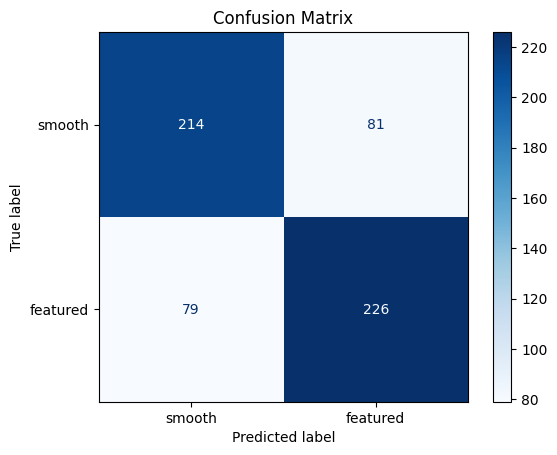

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pickle


load_from = 'smooth_featured_LLE_120_neighbours_5.pkl'


with open(load_from, 'rb') as f:
  data = pickle.load(f)
  X_embedded = data['X_embedded']
  y = data['y']
  class_map = data['class_map']

# Step 1: Split dataset into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X_embedded, y, test_size=0.3, random_state=42, stratify=y)

# Step 2: Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 3: Fit multinomial logistic regression
model = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Step 4: Make predictions
y_pred = model.predict(X_test)

# Step 5: Generate confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=list(class_map.keys()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_map.values())
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()